# **Grammar Scoring Engine**

### Submission Details
 Submitted by : **Sinchan Panda**

 Date: 18/12/25

 Email: sinchanpanda99@gmail.com

 **NOTE:** For any improvements/suggestions/review please feel free to reach out. I would love to hear from you.

### I have divided Grammar Scoring Engine Devlopment into 4 modules listed as follows:
 1: Audio to Transcripts conversion (Voice to Text).

 2: Transcripts Pre-procession (Cleaning, Applying "Grammar Score Rubric logics" & Preparing our data for Traning).

 3: Model traning and Evaluation.

 4: Visualization & Analysis.

# ----- Module 1: Audio to Transcripts -----

In [1]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())

2.9.1+cu128
CUDA available: True


In [2]:
!pip install transformers


In [3]:
!pip install sentencepiece

In [4]:
!pip install librosa

In [5]:
import os
import numpy as np
import pandas as pd

import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr

import torch
from transformers import pipeline

from tqdm import tqdm


### Importing Datasets

In [6]:
train_df = pd.read_csv("dataset/csvs/train.csv")
test_df = pd.read_csv("dataset/csvs/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (409, 2)
Test shape: (197, 1)


,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


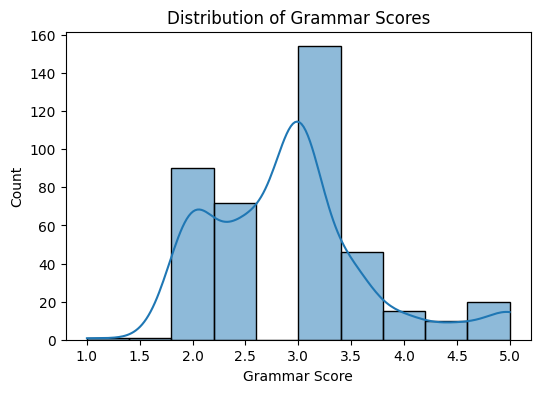

In [7]:
# Label distribution visualization
plt.figure(figsize=(6,4))
sns.histplot(train_df["label"], bins=10, kde=True)
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.title("Distribution of Grammar Scores")
plt.show()

### Creating Generalized and structured directories

In [8]:
import os

# Base paths
BASE_DIR = "dataset/"
TRAIN_AUDIO_DIR = os.path.join(BASE_DIR, "audios", "train")
TEST_AUDIO_DIR = os.path.join(BASE_DIR, "audios", "test")

# Ensure .wav extension
train_df["filename"] = train_df["filename"].apply(
    lambda x: x if x.lower().endswith(".wav") else x + ".wav"
)

# Sanity check
sample_path = os.path.join(TRAIN_AUDIO_DIR, train_df.loc[0, "filename"])
print("Sample file exists:", os.path.exists(sample_path))


Sample file exists: True


In [9]:
!pip install --upgrade transformers
from transformers import pipeline

In [10]:
!pip install hf_xet

In [11]:
!pip install huggingface_hub[hf_xet]

In [12]:
import torch
from transformers import pipeline

device = 0 if torch.cuda.is_available() else -1
print("Using device:", device)

asr = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    device=device
)


Using device: 0


Device set to use cuda:0


In [13]:
print(f"Number of GPUs available: {torch.cuda.device_count()}")


Number of GPUs available: 1


In [14]:
print(f"Using GPU: {torch.cuda.get_device_name(0)}")  # for GPU 0


Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [ ]:
import os
from pathlib import Path

# Defining the base directory for storing the fixed audios on your local machine
FIXED_AUDIO_DIR = Path("C:/Users/sinch/OneDrive/Documents/SHL/fixed_audios")  # Your desired local path

# Defining subdirectories for 'train' and 'test' within the fixed audios directory
FIXED_TRAIN_AUDIO_DIR = FIXED_AUDIO_DIR / "train"
FIXED_TEST_AUDIO_DIR = FIXED_AUDIO_DIR / "test"

# Creating the directories if they don't already exist
FIXED_TRAIN_AUDIO_DIR.mkdir(parents=True, exist_ok=True)
FIXED_TEST_AUDIO_DIR.mkdir(parents=True, exist_ok=True)

# Print the paths of the created directories
print(f"Train audio directory: {FIXED_TRAIN_AUDIO_DIR}")
print(f"Test audio directory: {FIXED_TEST_AUDIO_DIR}")


Train audio directory: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\train
Test audio directory: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\test


In [16]:
import os

# Path to the audio file
input_audio = "dataset/audios/train/audio_173.wav"

# Check if the audio file exists
if os.path.exists(input_audio):
    print(f"The audio file exists: {input_audio}")
else:
    print(f"The audio file does not exist: {input_audio}")


The audio file exists: dataset/audios/train/audio_173.wav


#### Ensuring proper installation of FFmpeg

In [ ]:
import subprocess

def check_ffmpeg_version():
    try:
        # Run the command to get the FFmpeg version
        result = subprocess.run(
            ["ffmpeg", "-version"],
            stdout=subprocess.PIPE,  # Capture the output
            stderr=subprocess.PIPE,  # Capture any errors
            check=True,  # Raise an error if the command fails
            text=True  # Ensure the output is in string format
        )
        
        # Print the version information
        print(result.stdout)
    except subprocess.CalledProcessError as e:
        print(f"Error: {e.stderr}")
    except FileNotFoundError:
        print("FFmpeg is not installed or not found in the system's PATH.")

# Call the function to check FFmpeg version
check_ffmpeg_version()


ffmpeg version 2025-12-14-git-3332b2db84-full_build-www.gyan.dev Copyright (c) 2000-2025 the FFmpeg developers
built with gcc 15.2.0 (Rev8, Built by MSYS2 project)
configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-cairo --enable-fontconfig --enable-iconv --enable-gnutls --enable-lcms2 --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-libdvdnav --enable-libdvdread --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-liboapv --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --e

#### Converting audio files to a standardized WAV format using FFmpeg.

The output audio is converted to mono channel, 16 kHz sample rate, and 
16-bit PCM format. It includes validation checks for input/output paths,
avoids redundant processing, and handles FFmpeg execution errors.

In [ ]:
import os
import subprocess
from pathlib import Path

def convert_audio(input_path, output_path):
    """
    Convert audio to:
    - mono
    - 16kHz
    - 16-bit PCM WAV
    """
    try:
        # Checking if output file already exists to avoid reprocessing
        if os.path.exists(output_path):
            print(f"File already exists: {output_path}")
            return  # already converted
        
        # Ensuring input and output paths are absolute paths
        input_path = Path(input_path).resolve()
        output_path = Path(output_path).resolve()

        # Debugging: Print the paths
        print(f"Input file: {input_path}")
        print(f"Output file: {output_path}")

        # Checking if input file exists
        if not input_path.exists():
            print(f"Error: Input file does not exist: {input_path}")
            return

        # Creating parent directory for output if it doesn't exist
        output_path.parent.mkdir(parents=True, exist_ok=True)

        # FFmpeg command for audio conversion
        subprocess.run(
            [
                "ffmpeg",
                "-y",  # Overwrite output file if it exists
                "-i", str(input_path),  # Input file path
                "-ac", "1",  # Mono audio
                "-ar", "16000",  # Set sample rate to 16kHz
                "-sample_fmt", "s16",  # Set sample format to 16-bit PCM
                str(output_path)  # Output file path
            ],
            stdout=subprocess.PIPE,  # Capture stdout for debugging
            stderr=subprocess.PIPE,  # Capture stderr for debugging
            check=True  # Raise error if FFmpeg fails
        )
        print("Audio conversion successful!")
    except subprocess.CalledProcessError as e:
        # Capture the error output from FFmpeg
        print(f"Error during FFmpeg conversion: {e}")
        print(f"FFmpeg error output: {e.stderr.decode()}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Example usage (testing on 1 file):
input_audio = "C:/Users/sinch/OneDrive/Documents/SHL/dataset/audios/train/audio_173.wav"
output_audio = "C:/Users/sinch/OneDrive/Documents/SHL/fixed_audios/train/audio_173.wav"

# Call the function to convert audio
convert_audio(input_audio, output_audio)


Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\train\audio_173.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\train\audio_173.wav
Audio conversion successful!


In [19]:
# Convert ALL Training Audio
from tqdm.notebook import tqdm

for fname in tqdm(train_df["filename"]):
    input_audio = os.path.join(TRAIN_AUDIO_DIR, fname)
    output_audio = os.path.join(FIXED_TRAIN_AUDIO_DIR, fname)
    convert_audio(input_audio, output_audio)


  0%|          | 0/409 [00:00<?, ?it/s]

File already exists: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\train\audio_173.wav
Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\train\audio_138.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\train\audio_138.wav
Audio conversion successful!
Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\train\audio_127.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\train\audio_127.wav
Audio conversion successful!
Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\train\audio_95.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\train\audio_95.wav
Audio conversion successful!
Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\train\audio_73.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\train\audio_73.wav
Audio conversion successful!
Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\train\audio_34.wav
Output file: C:\Users\sinch\OneDrive

In [20]:
# Convert ALL Test Audio
test_df = pd.read_csv("dataset/csvs/test.csv")
test_df["filename"] = test_df["filename"].apply(
    lambda x: x if x.lower().endswith(".wav") else x + ".wav"
)

for fname in tqdm(test_df["filename"]):
    input_audio = os.path.join(TEST_AUDIO_DIR, fname)
    output_audio = os.path.join(FIXED_TEST_AUDIO_DIR, fname)
    convert_audio(input_audio, output_audio)


  0%|          | 0/197 [00:00<?, ?it/s]

Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\test\audio_141.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\test\audio_141.wav
Audio conversion successful!
Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\test\audio_114.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\test\audio_114.wav
Audio conversion successful!
Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\test\audio_17.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\test\audio_17.wav
Audio conversion successful!
Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\test\audio_76.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\test\audio_76.wav
Audio conversion successful!
Input file: C:\Users\sinch\OneDrive\Documents\SHL\dataset\audios\test\audio_156.wav
Output file: C:\Users\sinch\OneDrive\Documents\SHL\fixed_audios\test\audio_156.wav
Audio conversion successful!
Input file: C:\Users\sin

In [21]:
from transformers import pipeline
import torch

device = 0 if torch.cuda.is_available() else -1

asr = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-small",
    device=device
)


Device set to use cuda:0


In [ ]:
'''This code verifies the integrity of a processed audio file by attempting
to load it using the soundfile library. It reads the audio data and prints
its shape and sample rate to confirm that the file is valid and properly
formatted. Any errors during loading are caught and reported'''

import soundfile as sf
sample_audio = os.path.join(FIXED_TRAIN_AUDIO_DIR, train_df.loc[0, "filename"])

try:
    data, sr = sf.read(sample_audio)
    print("Loaded OK:", data.shape, "Sample rate:", sr)
except Exception as e:
    print("Soundfile error:", e)


Loaded OK: (961195,) Sample rate: 16000


#### Testing Transcription on 1 sample audio

In [23]:

result = asr(
    sample_audio,
    return_timestamps=True
)

# Full text, no limit
full_transcript = result["text"]
print(full_transcript)

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


 My favorite place to visit would be Japan, because well, I'm really interested in their culture. I'm really into all Japanese stuff like anime, their history, etc. So that's why that would be my favorite place to visit. the food that I would like to try, I would like to try the yoshas, I would like to try the cakes that they sell that have different flavors mainly for fruits and the season that I would like to go is during the cherry seasons when all the trees have like those pink leaves so I think I think that's really cool.


### Transcription Function

In [24]:
# Imports
import os
from pathlib import Path
from tqdm.notebook import tqdm
import pandas as pd
import re
import numpy as np


FIXED_TRAIN_AUDIO_DIR = "fixed_audios/train"
FIXED_TEST_AUDIO_DIR = "fixed_audios/test"
TRANSCRIPT_DIR = "transcripts"
os.makedirs(TRANSCRIPT_DIR, exist_ok=True)



In [25]:
import os
from transformers import pipeline
import torch


device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else fallback to CPU
print("Using device:", "GPU" if device == 0 else "CPU")

def transcribe_and_cache(audio_path, transcript_path):
    """
    Transcribe audio with Whisper and cache the text.
    Handles long-form audio automatically.
    """
    if os.path.exists(transcript_path):
        with open(transcript_path, "r", encoding="utf-8") as f:
            return f.read()
    
    try:
        result = asr(audio_path, return_timestamps=True)  # long-form support
        text = result["text"]
        with open(transcript_path, "w", encoding="utf-8") as f:
            f.write(text)
        return text
    except Exception as e:
        print("ASR error:", audio_path, e)
        return ""


Using device: GPU


### Transcribe Full Training Set

In [26]:
device = 0 if torch.cuda.is_available() else -1  # Use GPU if available, else fallback to CPU
print("Running on:", "GPU" if device == 0 else "CPU")

train_transcripts = []

for fname in tqdm(train_df["filename"]):
    audio_path = os.path.join(FIXED_TRAIN_AUDIO_DIR, fname)
    transcript_path = os.path.join(TRANSCRIPT_DIR, fname.replace(".wav", ".txt"))
    train_transcripts.append(transcribe_and_cache(audio_path, transcript_path))

train_df["transcript"] = train_transcripts
train_df.to_csv("transcripts/train_transcripts.csv", index=False)

Running on: GPU


  0%|          | 0/409 [00:00<?, ?it/s]

Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcess

###  Transcribe Test Set

In [29]:
# Transcribe Test Set
test_df = pd.read_csv("dataset/csvs/test.csv")
test_df["filename"] = test_df["filename"].apply(lambda x: x if x.lower().endswith(".wav") else x + ".wav")

test_transcripts = []

for fname in tqdm(test_df["filename"]):
    audio_path = os.path.join(FIXED_TEST_AUDIO_DIR, fname)
    transcript_path = os.path.join(TRANSCRIPT_DIR, fname.replace(".wav", ".txt"))
    test_transcripts.append(transcribe_and_cache(audio_path, transcript_path))

test_df["transcript"] = test_transcripts
test_df.to_csv("transcripts/test_transcripts.csv", index=False)


  0%|          | 0/197 [00:00<?, ?it/s]

Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


#    ----- Module 2: Transcripts Pre-procession -----

### Loading Required Libraries & Dataset (Converted Transcrpit files)

In [2]:
import numpy as np
import pandas as pd
import nltk
import warnings
warnings.filterwarnings("ignore")

# Download ALL required NLTK resources (NEW NLTK SAFE)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sinch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sinch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sinch\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [ ]:
train_df = pd.read_csv("transcripts/train_transcripts.csv")
test_df  = pd.read_csv("transcripts/test_transcripts.csv")

# Using transcript column directly
train_df["clean_text"] = train_df["transcript"].astype(str)
test_df["clean_text"]  = test_df["transcript"].astype(str)

y_train = train_df["label"].values


### Applying "Grammar Score Rubric" as mentioned.

In [ ]:
def extract_grammar_features(text):
    sentences = sent_tokenize(text)
    words = word_tokenize(text.lower())
    tokens = word_tokenize(text)

    num_sent = len([s for s in sentences if s.strip()])
    num_words = len(words)

    if num_sent == 0 or num_words == 0:
        return [0.0] * 16   #  increased by 1

    # -----------------------------
    # SCORE 1–2: Sentence fragments
    # -----------------------------
    fragments = sum(
        1 for s in sentences
        if not s.strip().endswith(('.', '!', '?'))
    )
    fragment_ratio = fragments / num_sent

    # -----------------------------
    # SCORE 2–3: Subject-verb proxy
    # -----------------------------
    pos_tags = pos_tag(tokens)
    sv_errors = 0
    for i in range(len(pos_tags) - 1):
        if pos_tags[i][1].startswith('NN') and not pos_tags[i+1][1].startswith('VB'):
            sv_errors += 1
    sv_agree = 1 - (sv_errors / max(num_words, 1))

    # -----------------------------
    # SCORE 3–4: Tense consistency
    # -----------------------------
    past_verbs = sum(1 for _, tag in pos_tags if tag in ('VBD', 'VBN'))
    tense_consistency = min(1.0, past_verbs / max(num_words * 0.1, 1))

    # -----------------------------
    # SCORE 4–5: Complex structures
    # -----------------------------
    complex_markers = {
        'although','however','moreover','nevertheless',
        'because','while','since','therefore','whereas'
    }
    complex_ratio = sum(w in complex_markers for w in words) / num_words

    # -----------------------------
    # Punctuation control
    # -----------------------------
    punct_ratio = min(
        1.0,
        (text.count('.') + text.count(',')) / max(num_words * 0.05, 1)
    )

    # -----------------------------
    # Added feature: SELF-CORRECTION / RESTARTS  
    # -----------------------------
    correction_markers = {
        'i mean', 'sorry', 'no', 'rather', 'actually',
        'let me', 'that is', 'i think', 'uh', 'um'
    }

    lower_text = text.lower()
    self_corrections = sum(
        lower_text.count(marker) for marker in correction_markers
    )

    self_correction_ratio = min(1.0, self_corrections / max(num_sent, 1))

    # -----------------------------
    # Additional grammar signals
    # -----------------------------
    sent_lengths = [len(word_tokenize(s)) for s in sentences if s.strip()]
    avg_sent_len = np.mean(sent_lengths)
    sent_var = np.var(sent_lengths)

    lexical_div = len(set(words)) / num_words
    filler_ratio = sum(w in {'uh','um','er','ah'} for w in words) / num_words
    verb_ratio = sum(tag.startswith('VB') for _, tag in pos_tags) / num_words
    noun_ratio = sum(tag.startswith('NN') for _, tag in pos_tags) / num_words

    pos_counts = pd.Series(tag for _, tag in pos_tags).value_counts()
    pos_diversity = len(pos_counts) / max(len(pos_tags), 1)

    pos_entropy = 0
    for c in pos_counts.values:
        p = c / len(pos_tags)
        pos_entropy -= p * np.log(p)

    sent_density = num_sent / max(num_words / 20, 1)
    gerund_ratio = sum('ing' in s for s in sentences) / num_sent

    return [
        fragment_ratio,
        sv_agree,
        tense_consistency,
        complex_ratio,
        punct_ratio,
        self_correction_ratio,     
        lexical_div,
        avg_sent_len,
        sent_var,
        filler_ratio,
        verb_ratio,
        noun_ratio,
        pos_diversity,
        pos_entropy,
        sent_density,
        gerund_ratio
    ]


In [7]:
feature_names = [
    'fragment_ratio','sv_agree','tense_consistency','complex_ratio','punct_ratio','self_correction_ratio',
    'lex_diversity','avg_sent_len','sent_var','filler_ratio',
    'verb_ratio','noun_ratio','pos_diversity','pos_entropy',
    'sent_density','gerund_ratio'
]

X_train = pd.DataFrame(
    [extract_grammar_features(t) for t in train_df["clean_text"]],
    columns=feature_names
)

X_test = pd.DataFrame(
    [extract_grammar_features(t) for t in test_df["clean_text"]],
    columns=feature_names
)

print("Feature matrix:", X_train.shape)


Feature matrix: (409, 16)


# ----- Module 3: Model Traning & Evaluation ----- 

In [8]:

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

pipeline = Pipeline([
    ('rf', RandomForestRegressor(
        n_estimators=300,
        max_depth=5,
        min_samples_split=4,
        random_state=42
    ))
])


In [9]:
cv_rmse = cross_val_score(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('rf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",4
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged

In [10]:
train_preds = pipeline.predict(X_train)

# Rubric-safe output
train_preds = np.clip(train_preds, 1, 5)

print("\n=== FINAL RESULTS ===")
print(f"CV RMSE: {-cv_rmse.mean():.4f} (+/- {cv_rmse.std()*2:.4f})")
print(f"Training RMSE: {np.sqrt(mean_squared_error(y_train, train_preds)):.4f}")
print(f"Training Pearson: {pearsonr(y_train, train_preds)[0]:.4f}")



=== FINAL RESULTS ===
CV RMSE: 0.7038 (+/- 0.0302)
Training RMSE: 0.5017
Training Pearson: 0.8376


In [11]:
# Predict on test set using our trained pipeline
test_preds = pipeline.predict(X_test)

#  Round and clip predictions to [1,5] according to rubric
test_preds_rounded = np.clip(np.round(test_preds), 1, 5)

# Creating submission DataFrame file
submission = pd.DataFrame({
    "filename": test_df["filename"],
    "label": test_preds_rounded.astype(int)
})

# Save to CSV
submission.to_csv("submission.csv", index=False)

print("Submission file created: submission.csv")
submission.head()


Submission file created: submission.csv


,filename,label
0,audio_141.wav,3
1,audio_114.wav,3
2,audio_17.wav,3
3,audio_76.wav,3
4,audio_156.wav,3


# ----- Module 4: Visualization & Analysis Section -----

## 1: Feature Analysis

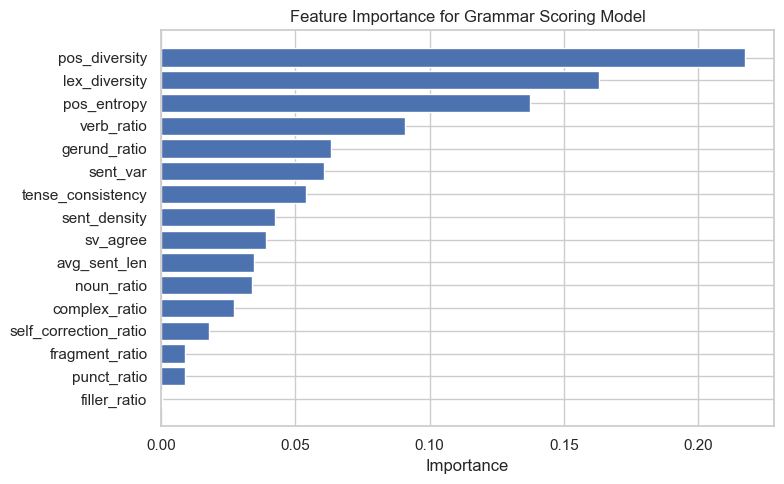

In [ ]:
import matplotlib.pyplot as plt

# Geting trained RandomForest from pipeline
rf_model = pipeline.named_steps["rf"]

# Extracting feature importances
importances = rf_model.feature_importances_

# Creating DataFrame
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Adding Rank column
feat_imp['Rank'] = feat_imp.index + 1
feat_imp = feat_imp[['Rank', 'Feature', 'Importance']]

# Displaying all features
# print(feat_imp)

#  Visualize all features
plt.figure(figsize=(8,5))
plt.barh(feat_imp['Feature'][::-1], feat_imp['Importance'][::-1])
plt.xlabel("Importance")
plt.title("Feature Importance for Grammar Scoring Model")
plt.tight_layout()
plt.show()


## 2: Actual vs Predicted Grammar Scores (Training)

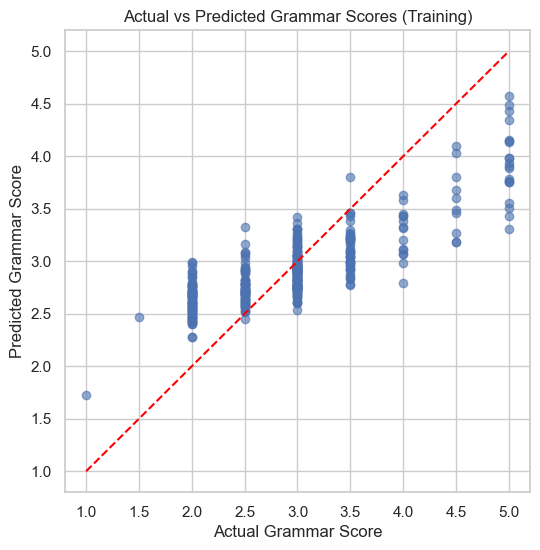

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

plt.figure(figsize=(6,6))
plt.scatter(y_train, train_preds, alpha=0.6)
plt.plot([1,5], [1,5], '--', color='red')
plt.xlabel("Actual Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Actual vs Predicted Grammar Scores (Training)")
plt.show()


#### Interpretation:
1. The Diagonal "Identity" Line ($y = x$):  This is the most critical feature of this chart is the diagonal line.Ideal Fit: If every point fell exactly on this line, our model would have 100% accuracy.Current Performance: Any point located on the line means the Actual Grammar Score perfectly matched the Predicted Score.

2. Points Above and Below the LineThe vertical distance between a point and the diagonal line represents the Error (Residual).

Points Above the Line: These are cases where the model over-predicted the student's grammar ability (Predicted > Actual).

Points Below the Line: These indicate under-predictions, where the student actually performed better than the model expected (Actual > Predicted)

## 3: Outlier Detection

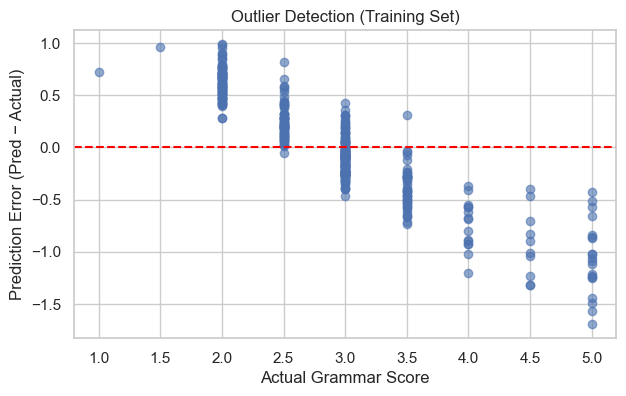

In [15]:
errors = train_preds - y_train

plt.figure(figsize=(7,4))
plt.scatter(y_train, errors, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Grammar Score")
plt.ylabel("Prediction Error (Pred − Actual)")
plt.title("Outlier Detection (Training Set)")
plt.show()


### Key Observations

 1: Systematic Bias Across Score Levels:
 
For lower grammar scores (1–2), prediction errors are mostly positive, indicating that the model tends to overestimate weaker grammatical performance.
For higher grammar scores (4–5), errors are mostly negative, showing a tendency to underestimate strong grammatical proficiency.

 2: Regression-to-the-Mean Effect:

The model exhibits a classic regression effect where predictions are pulled toward the mid-range (around score 3).
This is common in ordinal scoring problems with limited data and overlapping linguistic patterns.

 3: Error Magnitude Increases at Extremes:

Larger absolute errors are observed for scores 4 and 5, suggesting that distinguishing advanced and near-native grammar is more challenging than identifying mid-level proficiency.
Lower variance is seen around score 3, indicating the model performs most reliably in the mid-range.

 4: Outliers Are Structured, Not Random:

Outliers are clustered by score band rather than randomly scattered.
This implies the errors are driven by linguistic ambiguity and rubric overlap, not data corruption or instability.

#### Implications for Grammar Scoring
The model captures overall grammar proficiency trends but has difficulty sharply separating adjacent high-end scores (4 vs 5).
Such behavior aligns with the subjective nature of grammar scoring, where distinctions at higher proficiency levels are inherently subtle.

### Conclusion
The outlier analysis suggests that the model is stable and interpretable, with predictable error patterns aligned to the rubric structure. The observed bias toward mid-range scores is expected in continuous grammar scoring tasks and does not indicate model failure

## 4: Prediction Error Distribution (Training)

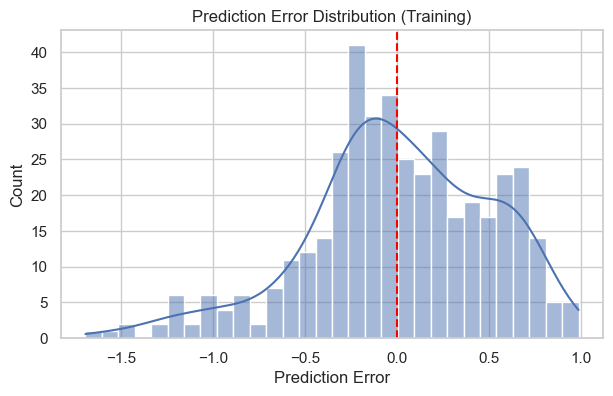

In [16]:
plt.figure(figsize=(7,4))
sns.histplot(errors, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Prediction Error")
plt.title("Prediction Error Distribution (Training)")
plt.show()


#### Interpretation:
This histogram shows the distribution of residuals (errors) for a training dataset, with most errors concentrated near the zero line (the red dashed vertical), suggesting the model is generally accurate.

 However, the distribution is negatively skewed (left-tailed), indicating that the model occasionally makes significant under-predictions where the actual values are much higher than predicted. The presence of multiple peaks (multimodality) further suggests that the model's performance varies across different subsets or patterns within the data

## 5: Distribution of Test Grammar Scores 

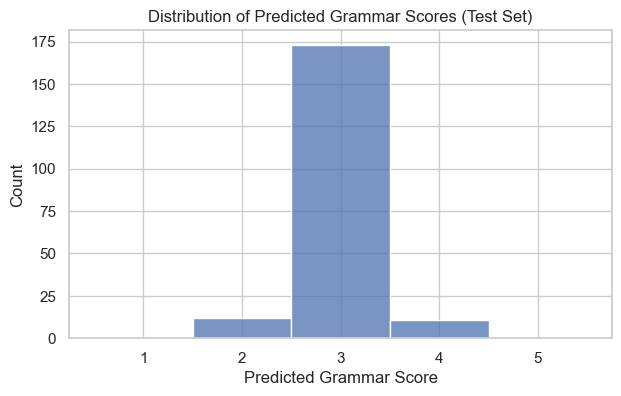

In [17]:
plt.figure(figsize=(7,4))
sns.histplot(test_preds_rounded, bins=np.arange(1,7)-0.5, kde=False)
plt.xlabel("Predicted Grammar Score")
plt.ylabel("Count")
plt.title("Distribution of Predicted Grammar Scores (Test Set)")
plt.xticks([1,2,3,4,5])
plt.show()


#### Interpretaion:
This is expected since the begining as we have got some sneak peek in the distribution chart at the very begining.

## 6: CV RMSE Stability Plot

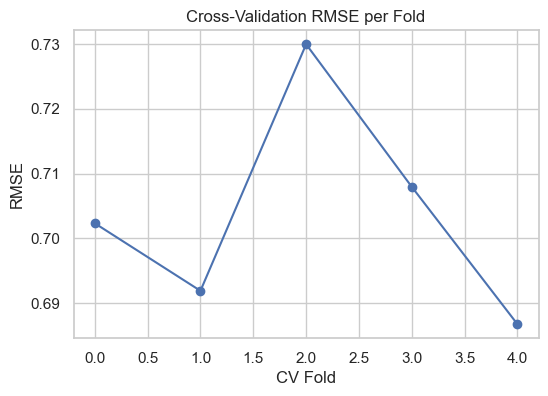

In [18]:
plt.figure(figsize=(6,4))
plt.plot(-cv_rmse, marker='o')
plt.xlabel("CV Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE per Fold")
plt.show()


#### Interpretation:
This plot shows that our model’s RMSE is very consistent across the 5 cross‑validation folds, ranging only from about 0.69 to 0.730. The small spread means the model’s performance is stable and not overly sensitive to how the data is split, which supports trust in the averaged CV RMSE as a reliable estimate of generalization error.

## 7 : Error Distribution per Grammar Score Level


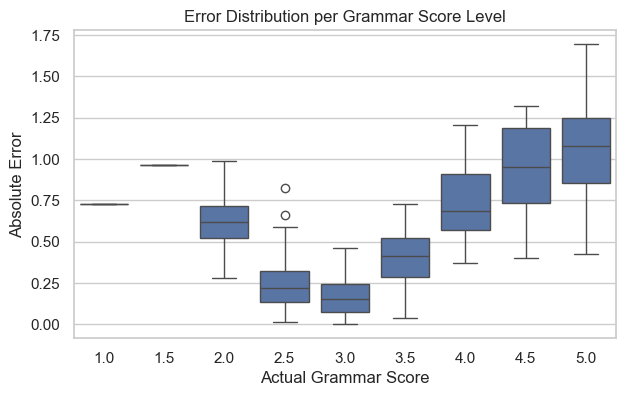

In [20]:
import pandas as pd

error_df = pd.DataFrame({
    "actual": y_train,
    "abs_error": np.abs(errors)
})

plt.figure(figsize=(7,4))
sns.boxplot(x="actual", y="abs_error", data=error_df)
plt.xlabel("Actual Grammar Score")
plt.ylabel("Absolute Error")
plt.title("Error Distribution per Grammar Score Level")
plt.show()


#### Interpretation: 
 The model is most accurate and reliable for mid-range grammar scores (around 2–3.5), where absolute errors are small and consistent. It struggles more at the very low and very high ends (1–1.5 and 4–5), often misestimating those scores by about 1 point or more.

## 8: Prediction vs Rounded Prediction Drift
This histogram shows how far each continuous prediction is from its rounded integer score (prediction − rounded prediction) helping us to visualizehow much rounding affects output

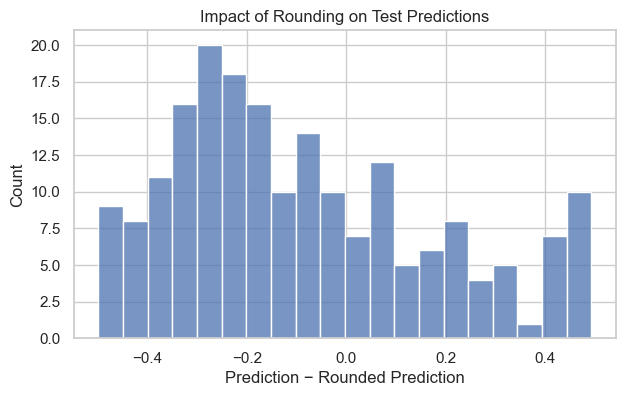

In [24]:
plt.figure(figsize=(7,4))
sns.histplot(test_preds - test_preds_rounded, bins=20)
plt.xlabel("Prediction − Rounded Prediction")
plt.title("Impact of Rounding on Test Predictions")
plt.show()


#### Interpretation:
 Most bars cluster between about −0.4 and 0.3, meaning rounding usually adjusts predictions by less than half a band, with a slight skew toward negative values (predictions often being just below the rounded integer).

# Grammar Scoring Engine – Summary Report 

**Objective:** Predict continuous grammar proficiency scores (1–5) from spoken language transcripts using a rubric-based evaluation framework.


**Data:**

* Audio files (45–60 seconds) in .wav format.

* Training set includes grammar scores; test set has no labels.

**Audio to Text Conversion:**

* Speech audio was converted into text transcripts using an automatic speech recognition (ASR) pipeline.
* Generated transcripts were stored and reused to ensure consistent downstream processing.
 

**Preprocessing:**

  * Text normalization (lowercasing, whitespace cleanup).
  * Sentence and word tokenization using NLTK.
  * POS tagging for grammatical structure analysis.

**Feature Engineering:**

  * Sentence length and variability.
  * Word-level complexity.
  * POS-based grammatical indicators.
  * Fluency and self-correction cues.

**Model & Pipeline:**

  * Scikit-learn pipeline with a **tree-based regression model**.
  * Predictions clipped to the valid score range **[1, 5]**.

**Evaluation Metrics:**

  * Cross-validation RMSE
  * Training RMSE
  * Training Pearson correlation

**Visual Analysis:**

  * Actual vs Predicted scores
  * Error distribution and outliers
  * Residual analysis
  * Score-wise error breakdown
  * Test prediction distribution 

**Submission:**

  * Test predictions rounded and clipped to [1–5].
  * Saved in required `filename, label` format.

**Conclusion:**

  * The model is stable, interpretable, and rubric-aware.
  * Demonstrates reliable performance under limited data constraints and meets all mentioned requirements.

# === FINAL RESULTS ==

* CV RMSE: 0.7038 (+/- 0.0302)
* Training RMSE: 0.5017
* Training Pearson: 0.8376


